In [3]:
suppressPackageStartupMessages(library(dplyr)) 
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(harmony))

library(ggplot2)
library(pheatmap)
library(RColorBrewer)
library(repr)

source("/projects/ps-renlab2/y2xie/scripts/basics.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT_help.R")

options(future.globals.maxSize = 64000 * 1024^2)

Warning message:
“package ‘pheatmap’ was built under R version 4.3.2”
Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: Rcpp

Warning message:
“package ‘dichromat’ was built under R version 4.3.2”
Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal




In [5]:
### Multiome kit barcode mapping
translate <- read.table("/projects/ps-renlab2/y2xie/ps-renlab/y2xie/projects/genome_ref/arc_bc-translation.txt", header = T, row.names = 1, sep = "\t")
translate$atac <- paste0(translate$atac, "-1")
translate$rna <- paste0(translate$rna, "-1")

In [ ]:
RunRNA2 <- function(obj, reduction = "pca", var = "none", batch.label = "none", k = 15) 
{
    if (var != "none") {
        obj <- SCTransform(obj, vars.to.regress = var, verbose = FALSE)
    }
    else {
        obj <- SCTransform(obj, verbose = FALSE)
    }
    obj <- RunPCA(obj, verbose = F)
    if (batch.label != "none") {
        obj <- RunHarmony(obj, group.by.vars = batch.label)
        reduction <- "harmony"
    }
    obj <- RunUMAP(obj, dims = 1:50, reduction = reduction, 
                   return.model = TRUE, seed.use = 921, metric = "cosine",
                   n.neighbors = k, min.dist = 0.1, n.components = 2L, umap.method = "uwot", 
                   uwot.sgd = TRUE, verbose = F)
    return(obj)
}

## Step1: Read in demul results

In [12]:
lmeta <- read.table('../scripts/heart_pool_metadata.xls', sep = "\t") %>% setNames(c("dna", "rna", "info"))
demul_list <- list()
for (f in lmeta$dna){
    dlib <- lmeta[lmeta$dna == f,]$dna
    rlib <- lmeta[lmeta$dna == f,]$rna
    demul_list[[f]] <- read.table(paste0("DPT.demux/", f, ".best"), header = T) %>% mutate(DNA_lib = dlib, RNA_lib = rlib)
}

demul_list <- do.call(rbind, demul_list)
dim(demul_list)

### need to add RNA barcode to demul_list
demul_list$RBARCODE <- translate[match(demul_list$BARCODE, translate$atac), ]$rna
saveRDS(demul_list, "DPT.demux/all.rds")

[1] 246834     22

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


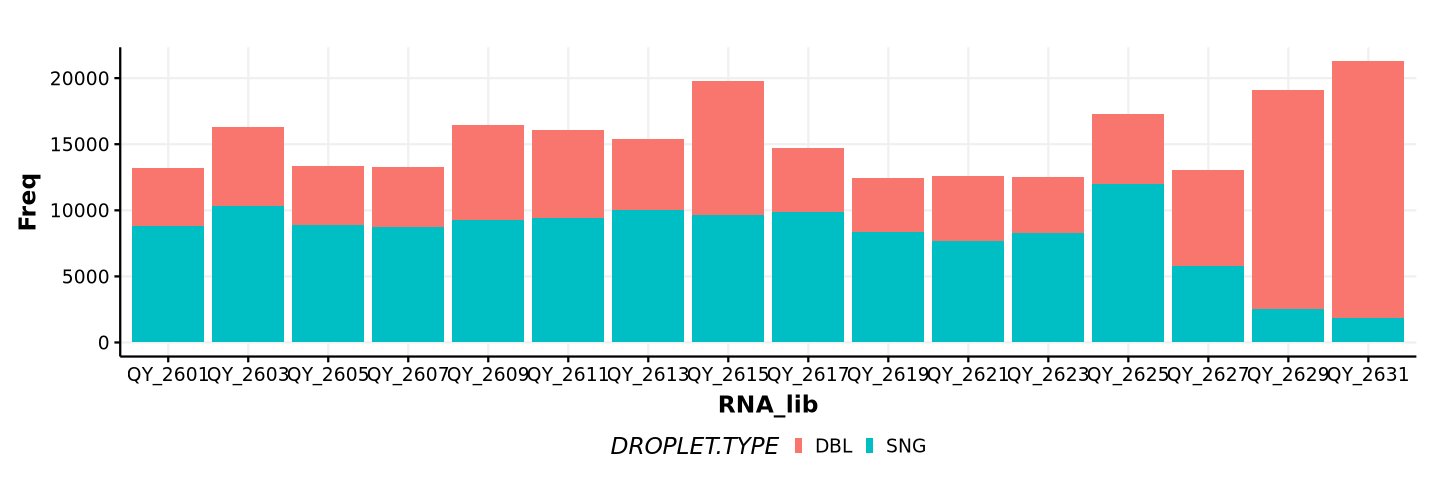

In [13]:
options(repr.plot.width = 12, repr.plot.height = 4)
demul_list %>%
select(c(RNA_lib, DROPLET.TYPE)) %>%
table %>% as.data.frame %>%
ggplot(aes(x = RNA_lib, y = Freq, fill = DROPLET.TYPE)) + 
geom_col(position = 'stack') + 
theme_Publication()

## Step2: Merge all processed Droplet Paired-Tag object

In [28]:
suppressPackageStartupMessages(library(foreach))
suppressPackageStartupMessages(library(doParallel))
registerDoParallel(cores = 16)

crna_list <- foreach(f = lmeta$rna, .packages = "Seurat") %dopar% {
    read_attempt <- try(readRDS(paste0("seurat_object/", f, ".rds")), silent = TRUE)
    if (inherits(read_attempt, "try-error")) {
        stop("Error reading ", f, "- skipping to next file.\n")
    }
    mmg <- readRDS(paste0("seurat_object/", f, ".rds"))
    tmp <- mmg@meta.data
    
    demul_list <- readRDS("DPT.demux/all.rds")
    demul_list <- demul_list[demul_list$RNA_lib == f, ]
    cvalid <- c("DROPLET.TYPE", "BEST.GUESS", "NEXT.GUESS")
    tmp[,cvalid] <- demul_list[match(rownames(tmp), demul_list$RBARCODE), cvalid]
    rownames(tmp) <- paste0(f, ":", rownames(tmp)) 
    
    mtx <- mmg[["RNA"]]@counts
    colnames(mtx) <- paste0(f, ":", colnames(mtx))
    return(list(mtx, tmp))
}

In [3]:
mtx_list <- lapply(crna_list, function(x) x[[1]])
meta_list <- lapply(crna_list, function(x) x[[2]])

tmp <- Reduce(cbind, mtx_list[-1], mtx_list[[1]]) ### dont use do.call for cbind
tmeta <- do.call(rbind, meta_list)
mmg <- CreateSeuratObject(tmp, meta.data = tmeta)
mmg@meta.data[,c("rna", "rna_bc")] <- stringr::str_split_fixed(colnames(mmg), pattern = ":", n = 2)
mmg@meta.data[,c("dna", "library_info")] <- lmeta[match(mmg$rna, lmeta$rna), c("dna", "info")]
                    
### Add DNA barcode
mmg$dna_bc <- translate[match(mmg$rna_bc, translate$rna), ]$atac
qry <- stringr::str_split_fixed(mmg$BEST.GUESS, pattern = ",", n = 3)[,1]
mmg@meta.data[,c("Donor", "Batch")] <- stringr::str_split_fixed(qry, pattern = "-", n = 4)[,c(3,4)]

### Add DNA modalities
mmg$Target <- NA
mmg@meta.data[grep('ac', mmg$library_info), ]$Target <- "H3K27ac"
mmg@meta.data[grep('me', mmg$library_info), ]$Target <- "H3K27me3"
table(mmg$Target)


 H3K27ac H3K27me3 
  115835   104297 

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


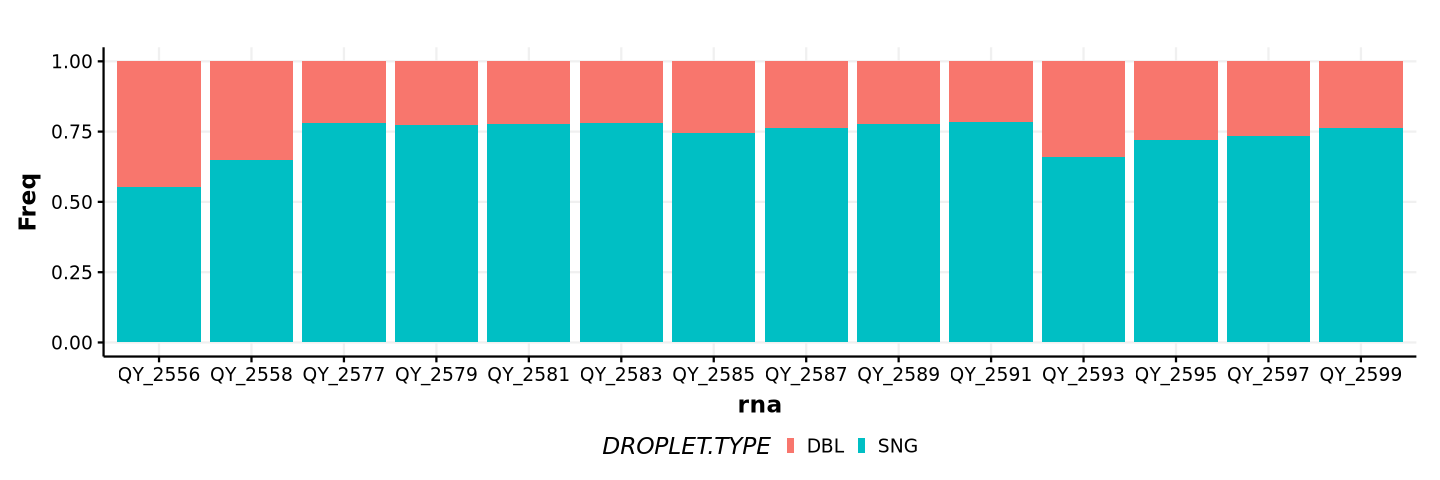

In [80]:
### Inspect filtered barcodes + demul results
options(repr.plot.width = 12, repr.plot.height = 4)
mmg@meta.data %>%
select(c(rna, DROPLET.TYPE)) %>%
table %>% as.data.frame %>%
ggplot(aes(x = rna, y = Freq, fill = DROPLET.TYPE)) + 
geom_col(position = 'fill') + 
theme_Publication()

In [81]:
qs::qsave(mmg, "FNIH_Heart_pool_DPT_raw.qs", preset = "balanced", nthreads = 32)

## Step3: QC and clustering

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”
Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”
Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



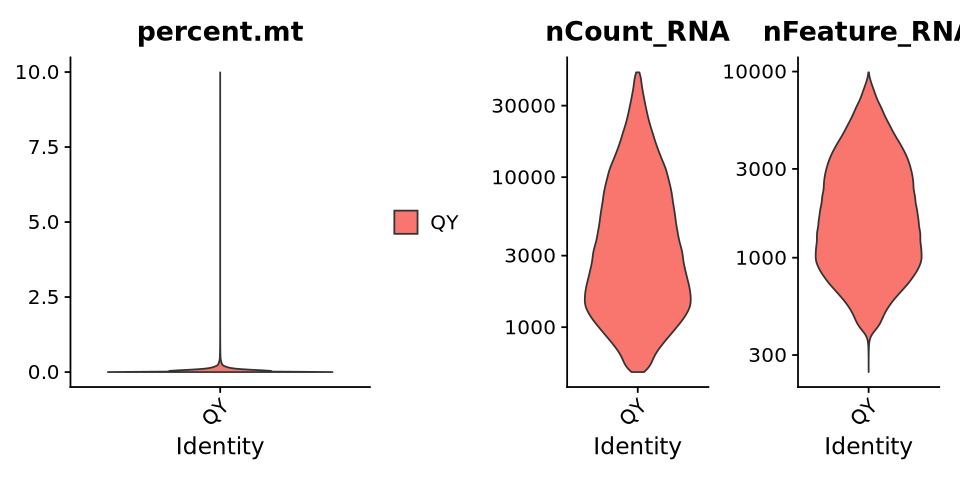

In [5]:
options(repr.plot.width = 8, repr.plot.height = 4)
t1 <- VlnPlot(mmg, "percent.mt", pt.size = 0)
t2 <- VlnPlot(mmg, c("nCount_RNA", "nFeature_RNA"), log = T, pt.size = 0)
cowplot::plot_grid(t1, t2)

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”
Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”
Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



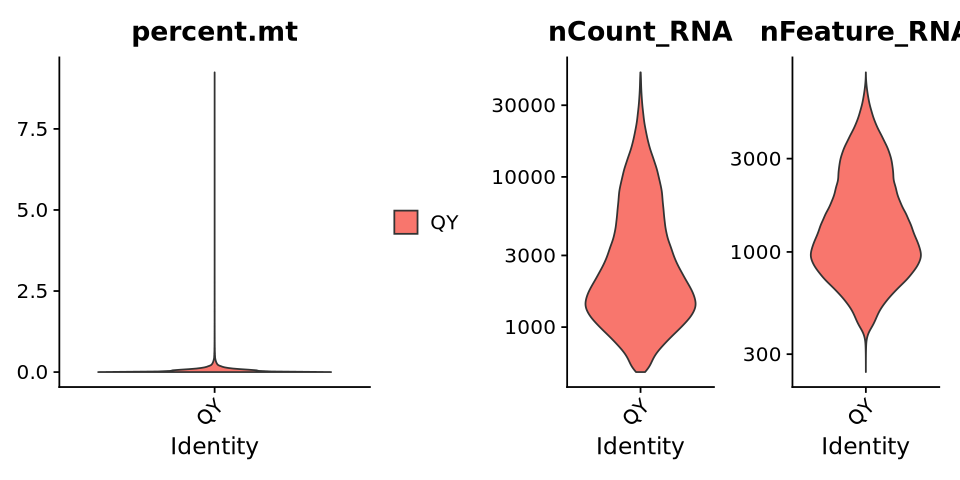

In [8]:
mmg <- subset(mmg, subset = DROPLET.TYPE == "SNG")

options(repr.plot.width = 8, repr.plot.height = 4)
t1 <- VlnPlot(mmg, "percent.mt", pt.size = 0)
t2 <- VlnPlot(mmg, c("nCount_RNA", "nFeature_RNA"), log = T, pt.size = 0)
cowplot::plot_grid(t1, t2)

In [ ]:
mmg@meta.data[grep("pool-1", mmg$library_info),]$chamber <- "RV"
mmg@meta.data[grep("pool-2", mmg$library_info),]$chamber <- "LA"
mmg@meta.data[grep("pool-3", mmg$library_info),]$chamber <- "RA"
mmg@meta.data[grep("pool-4", mmg$library_info),]$chamber <- "LV"

In [54]:
### Run SoupX
library(foreach)
library(doParallel)
registerDoParallel(cores = 16)

crna_list <- foreach(f = unique(mmg$rna), .packages = c("Seurat", "SoupX")) %dopar% {
    smmg <- subset(mmg, subset = rna == f)
    toc <- smmg@assays[["RNA"]]$counts
    tod <- Read10X(paste0("../RNA/", f, "/outs/raw_feature_bc_matrix"))
    colnames(tod) <- paste0(f, ":", colnames(tod))
    sc <- SoupChannel(tod, toc)
    sc <- setDR(sc, as.data.frame(smmg@reductions$umap@cell.embeddings))
    sc <- setClusters(sc, smmg$seurat_clusters)
    sc <- autoEstCont(sc)
    out <- adjustCounts(sc, roundToInt=TRUE)
    background <- sc$soupProfile[order(sc$soupProfile$est, decreasing=TRUE),]
    background$sample <- f
    return(list(out, background))
}

In [58]:
mtx_list <- lapply(crna_list, function(x) x[[1]])
bg <- do.call(rbind, lapply(crna_list, function(x) x[[2]]))
saveRDS(bg, "FNIH_Heart_pool_DPT_soupX_SNG.contam.rds")
                            
### merge object
tmp <- Reduce(cbind, mtx_list[-1], mtx_list[[1]]) ### dont use do.call for cbind
mmg2 <- CreateSeuratObject(tmp)
mmg2 <- subset(mmg2, cells = colnames(mmg))
mmg2@meta.data <- mmg@meta.data[colnames(mmg2), ]
                       
mmg2
gc()

An object of class Seurat 
36601 features across 136901 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)
 1 layer present: counts

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,11335273,605.4,34730766,1854.9,43413457,2318.6
Vcells,3567802116,27220.2,10990594604,83851.6,26832475154,204715.6


In [60]:
### correct batch effect based on donor pool instead of single donor
mmg2 <- RunRNA2(mmg2, batch.label = "library_info", k = 30) 
mmg2 <- FindNeighbors(object = mmg2, k.param = 30, reduction = "harmony", 
                      dims = 1:50, nn.method = "annoy", annoy.metric = "cosine", verbose = F)
mmg2 <- FindClusters(object = mmg2, algorithm = 4, method = "igraph", weights = T, resolution = 1, verbose = F)

gc()

Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“u

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,11338434,605.6,41136652,2197.0,50907608,2718.8
Vcells,4524292690,34517.7,14290358992,109026.8,27910167599,212937.7


In [61]:
qs::qsave(mmg2, "FNIH_Heart_pool_DPT_SNG_SoupX.qs", preset = "balanced", nthreads = 32)